<a href="https://colab.research.google.com/github/yakaralar/IE492/blob/master/cat_xg_boost_learning_to_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import glob
import shutil
os.listdir()

['.config', 'drive', 'sample_data']

In [3]:
absolute_path="drive/My Drive/colab_datas/IE 492"

In [4]:
os.listdir(absolute_path)

['Comparison of methods.pdf',
 '1-s2.0-S1364032114000914-main.pdf',
 '1-s2.0-S0360544209002539-main.pdf',
 '1-s2.0-S1876610211043116-main.pdf',
 '1-s2.0-S0305048311001423-main.pdf',
 'weather_turkey_processed.zip',
 'Meta_L_makaleler',
 'all_data.feather',
 'UECM-15012015-20022020.csv',
 'RealTimeConsumption-01122014-09032020.csv',
 'updated_support-date_based_information.r',
 'ozel_gunler',
 'RealTimeConsumption_unholidayized.csv',
 'RealTimeConsumption_unhol_decomposed.csv',
 'RealTimeConsumption_holiday.csv',
 'kubi_preds',
 'arima_preds.csv',
 'arima_preds_datetime.csv',
 'gpw_v4_admin_unit_center_points_population_estimates_rev11_tur.csv',
 'gpw-v4-country-level-summary-rev11.xlsx',
 'gpw-v4-documentation-rev11.pdf',
 'kubi_weather_data_20151231-2020-04-02.csv',
 'kubi_temp_humid_wind_data_20151231-2020-04-02.csv',
 'lasso_coeffs_new.csv',
 'Consumption_special_days_v2.csv']

In [5]:
shutil.copy(absolute_path+"/RealTimeConsumption_unholidayized.csv","./")
shutil.copy(absolute_path+"/RealTimeConsumption-01122014-09032020.csv","./")
shutil.copy(absolute_path+"/RealTimeConsumption_holiday.csv","./")
shutil.copy(absolute_path+"/kubi_temp_humid_wind_data_20151231-2020-04-02.csv","./")

'./kubi_temp_humid_wind_data_20151231-2020-04-02.csv'

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline
np.random.seed(1337)
from tqdm import tqdm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# eval func

In [7]:
!pip install graphviz
!pip install sklearn --upgrade
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,plot_tree

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df=[]
def eval_function(name_,y_true, y_pred,valid_df):
    """
    name_:kullanılan modelin ismi
    y_true:actual values
    y_pred:predicted values
    valid_df:modele verdiginiz sekliyle validation dataframe'i ve yanına datetime'ı
    """
    ap=absolute_path+"/kubi_preds/eval_plots/"+name_
    if not os.path.exists(ap):
        os.mkdir(ap)
    rmse_=np.sqrt(mean_squared_error(y_true,y_pred))
    rmsle_=np.sqrt(mean_squared_log_error(y_true,y_pred))
    mae_=mean_absolute_error(y_true,y_pred)
    mape_=mean_absolute_percentage_error(y_true, y_pred)
    mapes_each_period=[mean_absolute_percentage_error(y_true[i],y_pred[i]) for i in range(len(y_true))]
    mapes_each_period=pd.DataFrame(mapes_each_period,columns=["mapes"])
    mapes_each_period["Datetime"]=valid_df["Datetime"].iloc[-len(mapes_each_period):]
    print("RMSE: ",rmse_)
    print("RMSLE: ",rmsle_)
    print("MAE: ",mae_)
    print("MAPE: ",mape_)
    fig=plt.figure(figsize=(16,10))
    sns.scatterplot(x=y_pred,y=y_true)
    fig.savefig(absolute_path+"/kubi_preds/eval_plots/"+name_+"/actual_vs_predicted.png")
    plt.pause(0.01)
    fig=plt.figure(figsize=(16,10))
    sns.residplot(y_true,y_pred)
    plt.pause(0.01)
    fig.savefig(absolute_path+"/kubi_preds/eval_plots/"+name_+"/residplot.png")
    nchunks=6 # plot count
    fig,ax=plt.subplots(nrows=32,figsize=(32,125))
    valid_copy=valid_df.reset_index(drop=True).copy()

    for i,datetime_ in enumerate(np.array_split(valid_copy["Datetime"],32)):
        sns.lineplot(y=y_true[datetime_.index.tolist()],x=datetime_,color="green",ax=ax[i])
        sns.lineplot(y=y_pred[datetime_.index.tolist()],x=datetime_,color="red",ax=ax[i])
    fig.savefig(absolute_path+"/kubi_preds/eval_plots/"+name_+"/lineplot_pred_act_{}.png".format(i))

    fig,ax=plt.subplots(nrows=nchunks,figsize=(32,25))
    for i,datetime_ in enumerate(np.array_split(mapes_each_period,nchunks)):
        sns.lineplot(y="mapes",x="Datetime",data=datetime_,ax=ax[i])
    fig.savefig(absolute_path+"/kubi_preds/eval_plots/"+name_+"/lineplot_errors.png")

    # plt.pause(0.01)
    # res_model=DecisionTreeRegressor(max_depth=4)
    # _, ax = plt.subplots(figsize=(60, 60))  # whatever size you want
    # fig=res_model.fit(valid_df.drop(columns=["Datetime"]),y_true-y_pred)
    # plot_tree(fig,ax=ax,feature_names=valid_df.drop(columns=["Datetime"]).columns,fontsize=16)
    # plt.pause(0.01)
    # ## saatlik mape tanımla
    return name_, rmse_,rmsle_,mae_,mape_

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


# Consumption df

In [8]:
# # bruuuuuuuh
# cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
# cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
# cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
# cons_holiday_binary.head()

In [9]:
# catboostu 1 aylık yap

In [10]:
preds_paths=glob.glob(absolute_path+"/kubi_preds/*.csv")
preds_paths

['drive/My Drive/colab_datas/IE 492/kubi_preds/LR_2.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/naive_2.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/LR_2_7_w_dates.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/naive_7.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/LR_2_7.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/LR_7.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/ygur_rima_preds_datetime.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Cat1_48hours.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Cat2_categorical_48hours.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Cat1_24hours.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Cat2_categorical_24hours.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Keras_Basic_dense_24.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/Keras_Basic_dense_48.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/HW_26.05_15.17_48.csv',
 'drive/My Drive/colab_datas/IE 492/kubi_preds/HW

In [11]:
#a=pd.read_csv(absolute_path+"/kubi_preds/ygur_rima_preds_datetime.csv")
#a["Datetime"]=pd.to_datetime(a["Datetime"],format="%d/%m/%Y %H:%M")
#a=a.iloc[:,:-1]
#a.columns=["Datetime","Arima"]
#a.to_csv(absolute_path+"/kubi_preds/ygur_rima_preds_datetime.csv",index=False)

In [12]:
#path_=absolute_path+"/kubi_preds/erdem_HW_preds_new.csv"
#a=pd.read_csv(path_)
#a["Datetime"]=pd.to_datetime(a["Datetime"])
#a.loc[a["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")][["Datetime","HW_unhol_reg"]].to_csv(path_,index=False)

In [13]:
pred_dfs=[]
for i,path_ in enumerate(preds_paths):
    df=pd.read_csv(path_)
    if "rima" in path_:
        df["Datetime"]=pd.date_range('2019-02-01','2020-03-04',freq="H")[:-1]
    df.columns=["Datetime_"+str(i),path_.split("/")[-1].strip(".csv")]
    pred_dfs.append(df)
preds=pd.concat(pred_dfs,axis=1)
preds

,Datetime_0,LR_2,Datetime_1,naive_2,Datetime_2,LR_2_7_w_date,Datetime_3,naive_7,Datetime_4,LR_2_7,Datetime_5,LR_7,Datetime_6,ygur_rima_preds_datetime,Datetime_7,Cat1_48hour,Datetime_8,Cat2_categorical_48hour,Datetime_9,Cat1_24hour,Datetime_10,Cat2_categorical_24hour,Datetime_11,Keras_Basic_dense_24,Datetime_12,Keras_Basic_dense_48,Datetime_13,HW_26.05_15.17_48,Datetime_14,HW_26.05_15.17_24
0,2019-02-01 00:00:00,31744.801869,2019-02-01 00:00:00,31427.68,2019-02-01 00:00:00,31374.377264,2019-02-01 00:00:00,32021.03,2019-02-01 00:00:00,31872.179211,2019-02-01 00:00:00,32126.739766,2019-02-01 00:00:00,31948.68315,2019-02-01 00:00:00,31312.281942,2019-02-01 00:00:00,31368.284964,2019-02-01 00:00:00,31339.433448,2019-02-01 00:00:00,31421.093027,2019-02-01 00:00:00,31503.037,2019-02-01 00:00:00,31493.430,2019-02-01 00:00:00,30684.197615,2019-02-01 00:00:00,31084.609906
1,2019-02-01 01:00:00,30353.806407,2019-02-01 01:00:00,29554.05,2019-02-01 01:00:00,29685.964658,2019-02-01 01:00:00,30105.80,2019-02-01 01:00:00,30060.616031,2019-02-01 01:00:00,30503.032726,2019-02-01 01:00:00,29979.44233,2019-02-01 01:00:00,29321.171197,2019-02-01 01:00:00,29342.353761,2019-02-01 01:00:00,29885.517565,2019-02-01 01:00:00,29421.283832,2019-02-01 01:00:00,29815.424,2019-02-01 01:00:00,29617.531,2019-02-01 01:00:00,27926.819198,2019-02-01 01:00:00,28460.965800
2,2019-02-01 02:00:00,29429.213104,2019-02-01 02:00:00,28308.65,2019-02-01 02:00:00,28505.461085,2019-02-01 02:00:00,28730.71,2019-02-01 02:00:00,28791.507529,2019-02-01 02:00:00,29337.249341,2019-02-01 02:00:00,28720.68574,2019-02-01 02:00:00,28112.010835,2019-02-01 02:00:00,28313.998802,2019-02-01 02:00:00,28391.046167,2019-02-01 02:00:00,28539.136838,2019-02-01 02:00:00,28635.771,2019-02-01 02:00:00,28455.043,2019-02-01 02:00:00,26546.141624,2019-02-01 02:00:00,27083.696398
3,2019-02-01 03:00:00,28904.205359,2019-02-01 03:00:00,27601.48,2019-02-01 03:00:00,27855.221933,2019-02-01 03:00:00,27957.44,2019-02-01 03:00:00,28075.676511,2019-02-01 03:00:00,28681.681110,2019-02-01 03:00:00,28046.44589,2019-02-01 03:00:00,27611.726344,2019-02-01 03:00:00,27380.407098,2019-02-01 03:00:00,27894.855316,2019-02-01 03:00:00,27672.298537,2019-02-01 03:00:00,27855.768,2019-02-01 03:00:00,27712.234,2019-02-01 03:00:00,25968.405327,2019-02-01 03:00:00,26467.658898
4,2019-02-01 04:00:00,28714.921348,2019-02-01 04:00:00,27346.52,2019-02-01 04:00:00,27727.815649,2019-02-01 04:00:00,27802.84,2019-02-01 04:00:00,27896.662105,2019-02-01 04:00:00,28550.613245,2019-02-01 04:00:00,27738.71164,2019-02-01 04:00:00,27145.591865,2019-02-01 04:00:00,27480.197660,2019-02-01 04:00:00,27416.535458,2019-02-01 04:00:00,27332.009369,2019-02-01 04:00:00,27631.098,2019-02-01 04:00:00,27759.875,2019-02-01 04:00:00,25889.936371,2019-02-01 04:00:00,26387.724248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,2020-03-03 19:00:00,35049.21,2020-03-03 19:00:00,38763.630766,2020-03-03 19:00:00,39283.70,2020-03-03 19:00:00,37640.730230,2020-03-03 19:00:00,38283.936762,2020-03-03 19:00:00,39055.31804,2020-03-03 19:00:00,36533.611538,2020-03-03 19:00:00,37024.468681,2020-03-03 19:00:00,36842.214179,2020-03-03 19:00:00,36960.207088,2020-03-03 19:00:00,37731.016,2020-03-03 19:00:00,38331.830,2020-03-03 19:00:00,38763.053506,2020-03-03 19:00:00,38504.688094
9524,2020-03-03 20:00:00,34324.041524,2020-03-03 20:00:00,34901.84,2020-03-03 20:00:00,38428.945844,2020-03-03 20:00:00,38791.40,2020-03-03 20:00:00,37280.720755,2020-03-03 20:00:00,37866.571236,2020-03-03 20:00:00,38426.28253,2020-03-03 20:00:00,36400.613389,2020-03-03 20:00:00,37347.225005,2020-03-03 20:00:00,37298.866743,2020-03-03 20:00:00,37127.922048,2020-03-03 20:00:00,38224.590,2020-03-03 20:00:00,37396.150,2020-03-03 20:00:00,38194.641721,2020-03-03 20:00:00,38041.438614
9525,2020-03-03 21:00:00,33821.654912,2020-03-03 21:00:00,34225.14,2020-03-03 21:00:00,37491.797795,202

In [14]:
preds=preds[["Datetime_0"]+[i for i in preds.columns if not i.startswith("Datetime")]].rename(columns={"Datetime_0":"Datetime"})
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Cat1_24hour,Cat2_categorical_24hour,Keras_Basic_dense_24,Keras_Basic_dense_48,HW_26.05_15.17_48,HW_26.05_15.17_24
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31339.433448,31421.093027,31503.037,31493.430,30684.197615,31084.609906
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29885.517565,29421.283832,29815.424,29617.531,27926.819198,28460.965800
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28391.046167,28539.136838,28635.771,28455.043,26546.141624,27083.696398
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27894.855316,27672.298537,27855.768,27712.234,25968.405327,26467.658898
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27416.535458,27332.009369,27631.098,27759.875,25889.936371,26387.724248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,36842.214179,36960.207088,37731.016,38331.830,38763.053506,38504.688094
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37298.866743,37127.922048,38224.590,37396.150,38194.641721,38041.438614
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36169.047983,36589.808965,37079.137,36533.484,37232.506117,37117.778697
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35232.776345,35744.313864,35741.207,35341.290,35950.473223,35793.471400


In [15]:
preds.isna().sum()

Datetime                    0
LR_2                        0
naive_2                     0
LR_2_7_w_date               0
naive_7                     0
LR_2_7                      0
LR_7                        0
ygur_rima_preds_datetime    0
Cat1_48hour                 0
Cat2_categorical_48hour     0
Cat1_24hour                 0
Cat2_categorical_24hour     0
Keras_Basic_dense_24        0
Keras_Basic_dense_48        0
HW_26.05_15.17_48           0
HW_26.05_15.17_24           0
dtype: int64

In [16]:
# bruuuuuuuh
cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()

,Date,Hour,Consumption,Datetime,is_annelergunu,is_arife,is_babalargunu,is_cocukbayrami,is_cumhuriyet,is_elections,is_examination,is_genclikbayrami,is_holiday,is_iscibayrami,is_kadinlargunu,is_kandil,is_kurbanbayrami,is_kurbanbayramilkgun,is_kurbanoncesigunler,is_onbestemmuz,is_outlierdays,is_ramazanbayrami,is_ramazanbayramilkgun,is_ramazanbayramisonrasi,is_ramazangunler,is_ramazanilkgun,is_ramazanoncesigunler,is_school_days,is_school_end,is_school_start,is_semester,is_semester_days,is_sevgililergunu,is_single_day_holidays,is_summerTimes,is_summer_break,is_uzunbayram,is_winterTimes,is_winter_break,is_winter_break_schools,is_yilbasi,is_yilbasioncesi,is_zaferbayrami
0,31.12.2015,00:00,29590.88,2015-12-31 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,31.12.2015,01:00,27785.43,2015-12-31 01:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,31.12.2015,02:00,26516.53,2015-12-31 02:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,31.12.2015,03:00,26091.62,2015-12-31 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,31.12.2015,04:00,25871.54,2015-12-31 04:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [17]:
preds["reel"]=cons_holiday_binary.loc[cons_holiday_binary["Datetime"]>=pd.to_datetime("2019-02-01 00:00:00")][["Consumption"]].values
preds.Datetime=pd.to_datetime(preds.Datetime)
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Cat1_24hour,Cat2_categorical_24hour,Keras_Basic_dense_24,Keras_Basic_dense_48,HW_26.05_15.17_48,HW_26.05_15.17_24,reel
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31339.433448,31421.093027,31503.037,31493.430,30684.197615,31084.609906,31878.29
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29885.517565,29421.283832,29815.424,29617.531,27926.819198,28460.965800,30064.08
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28391.046167,28539.136838,28635.771,28455.043,26546.141624,27083.696398,28813.77
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27894.855316,27672.298537,27855.768,27712.234,25968.405327,26467.658898,27865.76
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27416.535458,27332.009369,27631.098,27759.875,25889.936371,26387.724248,27554.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,36842.214179,36960.207088,37731.016,38331.830,38763.053506,38504.688094,37936.79
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37298.866743,37127.922048,38224.590,37396.150,38194.641721,38041.438614,37553.37
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36169.047983,36589.808965,37079.137,36533.484,37232.506117,37117.778697,36581.73
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35232.776345,35744.313864,35741.207,35341.290,35950.473223,35793.471400,35434.36


In [18]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
mapes={}
calc_mapes=preds.set_index("Datetime")
for model_name in calc_mapes.columns[:-1]:
    y_true,y_pred=calc_mapes[["reel",model_name]].values.T
    mape_=mean_absolute_percentage_error(y_true,y_pred)
    mapes[model_name]=mape_
pd.DataFrame([list(mapes.keys()),list(mapes.values())]).T.sort_values(1)

,0,1
9,Cat1_24hour,2.61997
11,Keras_Basic_dense_24,2.8726
10,Cat2_categorical_24hour,2.94813
7,Cat1_48hour,2.99118
14,HW_26.05_15.17_24,3.01485
8,Cat2_categorical_48hour,3.24907
6,ygur_rima_preds_datetime,3.46533
12,Keras_Basic_dense_48,3.68307
13,HW_26.05_15.17_48,3.89177
2,LR_2_7_w_date,4.05324


In [20]:
preds["mean_models"]=preds[preds.columns.difference(["reel","Datetime"])].mean(axis=1)
preds["var_models"]=preds[preds.columns.difference(["reel","Datetime"])].std(axis=1)
preds

,Datetime,LR_2,naive_2,LR_2_7_w_date,naive_7,LR_2_7,LR_7,ygur_rima_preds_datetime,Cat1_48hour,Cat2_categorical_48hour,Cat1_24hour,Cat2_categorical_24hour,Keras_Basic_dense_24,Keras_Basic_dense_48,HW_26.05_15.17_48,HW_26.05_15.17_24,reel,mean_models,var_models
0,2019-02-01 00:00:00,31744.801869,31427.68,31374.377264,32021.03,31872.179211,32126.739766,31948.68315,31312.281942,31368.284964,31339.433448,31421.093027,31503.037,31493.430,30684.197615,31084.609906,31878.29,31514.790611,365.558605
1,2019-02-01 01:00:00,30353.806407,29554.05,29685.964658,30105.80,30060.616031,30503.032726,29979.44233,29321.171197,29342.353761,29885.517565,29421.283832,29815.424,29617.531,27926.819198,28460.965800,30064.08,29602.251900,653.520175
2,2019-02-01 02:00:00,29429.213104,28308.65,28505.461085,28730.71,28791.507529,29337.249341,28720.68574,28112.010835,28313.998802,28391.046167,28539.136838,28635.771,28455.043,26546.141624,27083.696398,28813.77,28393.354764,714.602171
3,2019-02-01 03:00:00,28904.205359,27601.48,27855.221933,27957.44,28075.676511,28681.681110,28046.44589,27611.726344,27380.407098,27894.855316,27672.298537,27855.768,27712.234,25968.405327,26467.658898,27865.76,27712.366955,705.356321
4,2019-02-01 04:00:00,28714.921348,27346.52,27727.815649,27802.84,27896.662105,28550.613245,27738.71164,27145.591865,27480.197660,27416.535458,27332.009369,27631.098,27759.875,25889.936371,26387.724248,27554.48,27521.403464,684.583136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,2020-03-03 19:00:00,34433.450000,35049.21,38763.630766,39283.70,37640.730230,38283.936762,39055.31804,36533.611538,37024.468681,36842.214179,36960.207088,37731.016,38331.830,38763.053506,38504.688094,37936.79,37546.737659,1377.029798
9524,2020-03-03 20:00:00,34324.041524,34901.84,38428.945844,38791.40,37280.720755,37866.571236,38426.28253,36400.613389,37347.225005,37298.866743,37127.922048,38224.590,37396.150,38194.641721,38041.438614,37553.37,37336.749961,1231.012770
9525,2020-03-03 21:00:00,33821.654912,34225.14,37491.797795,37588.86,36301.219739,36847.073493,37493.64405,35472.911196,36789.700181,36169.047983,36589.808965,37079.137,36533.484,37232.506117,37117.778697,36581.73,36450.250942,1099.671043
9526,2020-03-03 22:00:00,33102.945835,33257.06,36424.989624,36290.64,35168.705158,35746.459492,36200.27294,34919.122612,35609.855302,35232.776345,35744.313864,35741.207,35341.290,35950.473223,35793.471400,35434.36,35368.238853,949.064010


In [21]:
# get the rankings of each hour
ranking_each_hour={}
for idx,row in tqdm(preds.iterrows()):
    mape_period={i:mean_absolute_percentage_error(row[i],row["reel"]) for i in row[[i for i in row.index if i not in ["reel","Datetime"]]].index}
    ranking_each_hour[row["Datetime"]]=pd.DataFrame.from_dict({0:mape_period}).sort_values(0).index
ranking_each_hour

9528it [00:38, 246.80it/s]


{Timestamp('2019-02-01 00:00:00'): Index(['LR_2_7', 'ygur_rima_preds_datetime', 'LR_2', 'naive_7', 'LR_7',
        'mean_models', 'Keras_Basic_dense_24', 'Keras_Basic_dense_48',
        'naive_2', 'Cat2_categorical_24hour', 'LR_2_7_w_date',
        'Cat2_categorical_48hour', 'Cat1_24hour', 'Cat1_48hour',
        'HW_26.05_15.17_24', 'HW_26.05_15.17_48', 'var_models'],
       dtype='object'),
 Timestamp('2019-02-01 01:00:00'): Index(['LR_2_7', 'naive_7', 'ygur_rima_preds_datetime', 'Cat1_24hour',
        'Keras_Basic_dense_24', 'LR_2', 'LR_2_7_w_date', 'LR_7',
        'Keras_Basic_dense_48', 'mean_models', 'naive_2',
        'Cat2_categorical_24hour', 'Cat2_categorical_48hour', 'Cat1_48hour',
        'HW_26.05_15.17_24', 'HW_26.05_15.17_48', 'var_models'],
       dtype='object'),
 Timestamp('2019-02-01 02:00:00'): Index(['LR_2_7', 'naive_7', 'ygur_rima_preds_datetime', 'Keras_Basic_dense_24',
        'Cat2_categorical_24hour', 'LR_2_7_w_date', 'Keras_Basic_dense_48',
        'mean_model

In [22]:
def wmape(actual, forecast):
    forecast = np.array(forecast)
    actual=np.array(actual).reshape((-1, 1))
    se_mape = abs(actual-forecast)/actual
    ft_actual_sum = actual.sum(axis=0)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = se_actual_prod_mape.sum(axis=0)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast
wmape(preds["LR_2"],preds["reel"])

array([0.09377754, 0.11540075, 0.14020547, ..., 0.1206218 , 0.10224566,
       0.08933401])

In [23]:
train_df=[]
for idx,row in tqdm(preds.iterrows()):
    mape_period={i:wmape([row[i]],[row["reel"]])[0] for i in row[[i for i in row.index if i not in ["reel","var_models","mean_models","Datetime"]]].index}
    mapes_row=pd.DataFrame.from_dict({"mape":mape_period}).reset_index().rename(columns={"index":"model_names"})
    mapes_row["Datetime"]=row["Datetime"];
    mapes_row["preds"]=mapes_row["model_names"].apply(lambda x:row.to_dict()[x]);
    mapes_row["var_models"]=row["var_models"];
    mapes_row["mean_models"]=row["mean_models"];
    mapes_row=mapes_row.sort_values(by=["mape"]).reset_index(drop=True)
    train_df.append(mapes_row)
train_df=pd.concat(train_df).reset_index().rename(columns={"index":"ranking"})
train_df["ranking"]=train_df["ranking"]+1
train_df

9528it [01:46, 89.69it/s]


,ranking,model_names,mape,Datetime,preds,var_models,mean_models
0,1,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,365.558605,31514.790611
1,2,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,365.558605,31514.790611
2,3,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,365.558605,31514.790611
3,4,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,365.558605,31514.790611
4,5,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,365.558605,31514.790611
...,...,...,...,...,...,...,...
142915,11,Cat1_48hour,0.020924,2020-03-03 23:00:00,33133.711663,856.933398,33827.755797
142916,12,naive_7,0.021778,2020-03-03 23:00:00,34580.080000,856.933398,33827.755797
142917,13,LR_2_7_w_date,0.032761,2020-03-03 23:00:00,34972.751010,856.933398,33827.755797
142918,14,LR_2,0.055907,2020-03-03 23:00:00,32035.951504,856.933398,33827.755797


In [24]:
train_df["Datetime_numerized"]=train_df.Datetime.map({date:i+1  for i,date in enumerate(sorted(train_df.Datetime.unique()))})
train_df["model_names_num"]=train_df["model_names"].map({date:i+1  for i,date in enumerate(sorted(train_df["model_names"].unique()))})
train_df["ranking"]=np.abs(train_df["ranking"]-16)
train_df

,ranking,model_names,mape,Datetime,preds,var_models,mean_models,Datetime_numerized,model_names_num
0,15,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,365.558605,31514.790611,1,10
1,14,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,365.558605,31514.790611,1,15
2,13,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,365.558605,31514.790611,1,9
3,12,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,365.558605,31514.790611,1,14
4,11,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,365.558605,31514.790611,1,12
...,...,...,...,...,...,...,...,...,...
142915,5,Cat1_48hour,0.020924,2020-03-03 23:00:00,33133.711663,856.933398,33827.755797,9528,2
142916,4,naive_7,0.021778,2020-03-03 23:00:00,34580.080000,856.933398,33827.755797,9528,14
142917,3,LR_2_7_w_date,0.032761,2020-03-03 23:00:00,34972.751010,856.933398,33827.755797,9528,11
142918,2,LR_2,0.055907,2020-03-03 23:00:00,32035.951504,856.933398,33827.755797,9528,9


In [25]:
train_df

,ranking,model_names,mape,Datetime,preds,var_models,mean_models,Datetime_numerized,model_names_num
0,15,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,365.558605,31514.790611,1,10
1,14,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,365.558605,31514.790611,1,15
2,13,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,365.558605,31514.790611,1,9
3,12,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,365.558605,31514.790611,1,14
4,11,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,365.558605,31514.790611,1,12
...,...,...,...,...,...,...,...,...,...
142915,5,Cat1_48hour,0.020924,2020-03-03 23:00:00,33133.711663,856.933398,33827.755797,9528,2
142916,4,naive_7,0.021778,2020-03-03 23:00:00,34580.080000,856.933398,33827.755797,9528,14
142917,3,LR_2_7_w_date,0.032761,2020-03-03 23:00:00,34972.751010,856.933398,33827.755797,9528,11
142918,2,LR_2,0.055907,2020-03-03 23:00:00,32035.951504,856.933398,33827.755797,9528,9


In [26]:
weather_data=pd.read_csv('kubi_temp_humid_wind_data_20151231-2020-04-02.csv')
weather_data=weather_data.rename(columns={"rounded_date":"Datetime"})
weather_data["Datetime"]=pd.to_datetime(weather_data["Datetime"])
cons_holiday_binary=pd.merge(cons_holiday_binary,weather_data,on="Datetime",how="left")

In [27]:
cons_holiday_binary["Hour"]=cons_holiday_binary["Datetime"].apply(lambda x:x.hour).astype(int)
cons_holiday_binary["Day"]=cons_holiday_binary["Datetime"].apply(lambda x:x.day).astype(int)
cons_holiday_binary["Month"]=cons_holiday_binary["Datetime"].apply(lambda x:x.month).astype(int)
cons_holiday_binary["weekday"]=cons_holiday_binary["Datetime"].apply(lambda x: x.weekday()).astype(int)

In [28]:
train_df_copy=pd.merge(train_df,cons_holiday_binary[cons_holiday_binary.columns.difference(("Date","Hour","Consumption"))],on="Datetime",how="left")
X_train=train_df_copy.loc[train_df["Datetime"]<"2020-01-01"]
X_test=train_df_copy.loc[train_df["Datetime"]>="2020-01-01"]

In [29]:
# X_train=train_df.loc[train_df["Datetime"]<"2020-01-01"]
# X_test=train_df.loc[train_df["Datetime"]>="2020-01-01"]

### xgboost

In [30]:
import xgboost as xgb
xgbTrain = xgb.DMatrix(X_train.drop(columns=["mape","Datetime","model_names","ranking","Datetime_numerized"]), label = X_train["ranking"])
xgbTest = xgb.DMatrix(X_test.drop(columns=["mape","Datetime","model_names","ranking","Datetime_numerized"]), label = X_test["ranking"])
xgbTrain.set_group(X_train["Datetime_numerized"].value_counts().values)
xgbTest.set_group(X_test["Datetime_numerized"].value_counts().values)
# parametre eklenmesi gerekiyor
# rank:pairwise,rank:ndcg,rank:map
params = {'objective': 'rank:ndcg', 'eta': 0.05, 'gamma': 1.0,
          'min_child_weight': 0.1, 'max_depth': 6, "metric":"rank:pairwise"}
xgb_model = xgb.train(params, xgbTrain, num_boost_round=100,
                      evals=[(xgbTest, 'validation')])
pred = xgb_model.predict(xgbTest)

[0]	validation-map:1
[1]	validation-map:1
[2]	validation-map:1
[3]	validation-map:1
[4]	validation-map:1
[5]	validation-map:1
[6]	validation-map:1
[7]	validation-map:1
[8]	validation-map:1
[9]	validation-map:1
[10]	validation-map:1
[11]	validation-map:1
[12]	validation-map:1
[13]	validation-map:1
[14]	validation-map:1
[15]	validation-map:1
[16]	validation-map:1
[17]	validation-map:1
[18]	validation-map:1
[19]	validation-map:1
[20]	validation-map:1
[21]	validation-map:1
[22]	validation-map:1
[23]	validation-map:1
[24]	validation-map:1
[25]	validation-map:1
[26]	validation-map:1
[27]	validation-map:1
[28]	validation-map:1
[29]	validation-map:1
[30]	validation-map:1
[31]	validation-map:1
[32]	validation-map:1
[33]	validation-map:1
[34]	validation-map:1
[35]	validation-map:1
[36]	validation-map:1
[37]	validation-map:1
[38]	validation-map:1
[39]	validation-map:1
[40]	validation-map:1
[41]	validation-map:1
[42]	validation-map:1
[43]	validation-map:1
[44]	validation-map:1
[45]	validation-map:

### lgb

In [31]:
!pip install lightgbm --upgrade

     |████████████████████████████████| 1.2MB 3.5MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [32]:
X_train

,ranking,model_names,mape,Datetime,preds,var_models,mean_models,Datetime_numerized,model_names_num,Day,Month,dewpoint_Adana / Incirlik,dewpoint_Adana / Sakirpasa,dewpoint_Afyon,dewpoint_Akhisar,dewpoint_Ankara / Esenboga,dewpoint_Ankara / Etimesgut,dewpoint_Antalya,dewpoint_Aydin,dewpoint_Balikesir,dewpoint_Bandirma,dewpoint_Batman,dewpoint_Bodrum,dewpoint_Canakkale,dewpoint_Dalaman,dewpoint_Diyarbakir,dewpoint_Elazig,dewpoint_Erzincan,dewpoint_Erzurum,dewpoint_Eskisehir,dewpoint_Gaziantep,dewpoint_Iskenderun,dewpoint_Isparta,dewpoint_Isparta / Gölba??,dewpoint_Istanbul / Ataturk,dewpoint_Izmir / Adnan Menderes,dewpoint_Izmir / Cigli,dewpoint_Kars,dewpoint_Kayseri / Erkilet,dewpoint_Konya,...,temperature_Zonguldak,weekday,windspeed_Adana / Incirlik,windspeed_Adana / Sakirpasa,windspeed_Afyon,windspeed_Akhisar,windspeed_Ankara / Esenboga,windspeed_Ankara / Etimesgut,windspeed_Antalya,windspeed_Aydin,windspeed_Balikesir,windspeed_Bandirma,windspeed_Batman,windspeed_Bodrum,windspeed_Canakkale,windspeed_Dalaman,windspeed_Diyarbakir,windspeed_Elazig,windspeed_Erzincan,windspeed_Erzurum,windspeed_Eskisehir,windspeed_Gaziantep,windspeed_Iskenderun,windspeed_Isparta,windspeed_Isparta / Gölba??,windspeed_Istanbul / Ataturk,windspeed_Izmir / Adnan Menderes,windspeed_Izmir / Cigli,windspeed_Kars,windspeed_Kayseri / Erkilet,windspeed_Konya,windspeed_Malatya / Erhac,windspeed_Merzifon,windspeed_Murted Tur-Afb,windspeed_Sivas,windspeed_Tokat,windspeed_Trabzon,windspeed_Usak,windspeed_Van,windspeed_Zonguldak
0,15,LR_2_7,0.000192,2019-02-01 00:00:00,31872.179211,365.558605,31514.790611,1,10,1,2,9.5,9.4,-1.3,6.8,0.7,1.0,6.1,6.8,5.3,5.0,4.0,4.9,4.45,6.6,5.5,2.4,-2.2,-5.0,-0.2,6.4,8.300000,-0.8,2.0,6.0,3.2,3.9,-10.7,-1.9,0.2,...,9.1,4,9.0,13.0,16.7,1.8,21.0,16.6,8.0,0.0,7.6,24.1,5.4,7.4,17.65,21.0,5.0,13.0,7.6,4.0,3.6,8.0,5.4,5.4,22.3,30.0,4.0,13.0,9.4,24.0,18.0,7.6,5.4,20.5,29.5,18.4,30.0,9.4,5.0,9.0
1,14,ygur_rima_preds_datetime,0.002203,2019-02-01 00:00:00,31948.683150,365.558605,31514.790611,1,15,1,2,9.5,9.4,-1.3,6.8,0.7,1.0,6.1,6.8,5.3,5.0,4.0,4.9,4.45,6.6,5.5,2.4,-2.2,-5.0,-0.2,6.4,8.300000,-0.8,2.0,6.0,3.2,3.9,-10.7,-1.9,0.2,...,9.1,4,9.0,13.0,16.7,1.8,21.0,16.6,8.0,0.0,7.6,24.1,5.4,7.4,17.65,21.0,5.0,13.0,7.6,4.0,3.6,8.0,5.4,5.4,22.3,30.0,4.0,13.0,9.4,24.0,18.0,7.6,5.4,20.5,29.5,18.4,30.0,9.4,5.0,9.0
2,13,LR_2,0.004205,2019-02-01 00:00:00,31744.801869,365.558605,31514.790611,1,9,1,2,9.5,9.4,-1.3,6.8,0.7,1.0,6.1,6.8,5.3,5.0,4.0,4.9,4.45,6.6,5.5,2.4,-2.2,-5.0,-0.2,6.4,8.300000,-0.8,2.0,6.0,3.2,3.9,-10.7,-1.9,0.2,...,9.1,4,9.0,13.0,16.7,1.8,21.0,16.6,8.0,0.0,7.6,24.1,5.4,7.4,17.65,21.0,5.0,13.0,7.6,4.0,3.6,8.0,5.4,5.4,22.3,30.0,4.0,13.0,9.4,24.0,18.0,7.6,5.4,20.5,29.5,18.4,30.0,9.4,5.0,9.0
3,12,naive_7,0.004458,2019-02-01 00:00:00,32021.030000,365.558605,31514.790611,1,14,1,2,9.5,9.4,-1.3,6.8,0.7,1.0,6.1,6.8,5.3,5.0,4.0,4.9,4.45,6.6,5.5,2.4,-2.2,-5.0,-0.2,6.4,8.300000,-0.8,2.0,6.0,3.2,3.9,-10.7,-1.9,0.2,...,9.1,4,9.0,13.0,16.7,1.8,21.0,16.6,8.0,0.0,7.6,24.1,5.4,7.4,17.65,21.0,5.0,13.0,7.6,4.0,3.6,8.0,5.4,5.4,22.3,30.0,4.0,13.0,9.4,24.0,18.0,7.6,5.4,20.5,29.5,18.4,30.0,9.4,5.0,9.0
4,11,LR_7,0.007733,2019-02-01 00:00:00,32126.739766,365.558605,31514.790611,1,12,1,2,9.5,9.4,-1.3,6.8,0.7,1.0,6.1,6.8,5.3,5.0,4.0,4.9,4.45,6.6,5.5,2.4,-2.2,-5.0,-0.2,6.4,8.300000,-0.8,2.0,6.0,3.2,3.9,-10.7,-1.9,0.2,...,9.1,4,9.0,13.0,16.7,1.8,21.0,16.6,8.0,0.0,7.6,24.1,5.4,7.4,17.65,21.0,5.0,13.0,7.6,4.0,3.6,8.0,5.4,5.4,22.3,30.0,4.0,13.0,9.4,24.0,18.0,7.6,5.4,20.5,29.5,18.4,30.0,9.4,5.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120235,5,Keras_Basic_dense_48,0.146671,2019-12-31 23:00:00,34554.860000,855.658978,34050.643520,8016,8,31,12,7.0,6.0,-0.3,1.9,1.0,2.0,3.0,4.7,5.0,1.0,4.0,

In [33]:
import lightgbm as lgb

lgbTrain = lgb.Dataset(X_train.drop(columns=["mape","Datetime","model_names","ranking"]), label = X_train["ranking"])
lgbTest = lgb.Dataset(X_test.drop(columns=["mape","Datetime","model_names","ranking"]), label = X_test["ranking"])
lgbTrain.set_group(X_train["Datetime_numerized"].value_counts().values)
lgbTest.set_group(X_test["Datetime_numerized"].value_counts().values)
# parametre eklenmesi gerekiyor
params = {"objective":"lambdarank", 'eta': 0.1, 'max_depth': 8,"categorical_feature":[4,5]}
lgb_model = lgb.train(params, lgbTrain, num_boost_round=10000,early_stopping_rounds=5000,
                      valid_sets=lgbTest)
pred = lgb_model.predict(X_test.drop(columns=["mape","Datetime","model_names","Datetime_numerized"]))

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


LightGBMError: ignored

### catboost

In [34]:
!pip install catboost --upgrade

     |████████████████████████████████| 64.8MB 46kB/s 


In [ ]:
import catboost

params = {"objective":"YetiRankPairwise", 'eta': 0.1, 'max_depth': 8, "task_type":"GPU","verbose":1
          }

catTrain = catboost.Pool(X_train.drop(columns=["mape","Datetime","model_names_num","ranking"]), label = X_train["ranking"],cat_features=[0,4])
catTest = catboost.Pool(X_test.drop(columns=["mape","Datetime","model_names_num","ranking"]), label = X_test["ranking"],cat_features=[0,4])

catTrain.set_group_id(X_train["Datetime_numerized"])
catTest.set_group_id(X_test["Datetime_numerized"])

cat_model = catboost.train(catTrain, params, num_boost_round=10000,early_stopping_rounds=1000,eval_set=catTest)
pred = cat_model.predict(catTest)

Groupwise loss function. OneHotMaxSize set to 10


Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.8232505	best: 0.8232505 (0)	total: 2.4s	remaining: 6h 40m 27s
1:	test: 0.8267769	best: 0.8267769 (1)	total: 4.64s	remaining: 6h 26m 21s
2:	test: 0.8313186	best: 0.8313186 (2)	total: 6.88s	remaining: 6h 21m 52s
3:	test: 0.8378722	best: 0.8378722 (3)	total: 9.13s	remaining: 6h 20m 16s
4:	test: 0.8378387	best: 0.8378722 (3)	total: 11.4s	remaining: 6h 19m 12s
5:	test: 0.8470838	best: 0.8470838 (5)	total: 13.6s	remaining: 6h 18m 23s
6:	test: 0.8493271	best: 0.8493271 (6)	total: 15.9s	remaining: 6h 17m 40s
7:	test: 0.8512085	best: 0.8512085 (7)	total: 18.1s	remaining: 6h 17m 21s
8:	test: 0.8683766	best: 0.8683766 (8)	total: 20.4s	remaining: 6h 17m 7s
9:	test: 0.8680922	best: 0.8683766 (8)	total: 22.6s	remaining: 6h 17m 1s
10:	test: 0.8694902	best: 0.8694902 (10)	total: 24.9s	remaining: 6h 16m 47s
11:	test: 0.8706001	best: 0.8706001 (11)	total: 27.2s	remaining: 6h 16m 41s
12:	test: 0.8713660	best: 0.8713660 (12)	total: 29.4s	remaining: 6h 16m 39s
13:	test: 0.8736553	best: 0.8736553

In [ ]:
pred[:15]

In [ ]:
X_test["pred_ranks"]=pred
X_test=X_test.sort_values(by=["pred_ranks"],ascending=False)

In [ ]:
mapes_ltr=[]
for i in range(1,15):
    top_three=X_test.reset_index(drop=True).groupby("Datetime")["pred_ranks"].nlargest(i).reset_index()
    final_preds=X_test.reset_index(drop=True).iloc[top_three.reset_index()["level_1"].values]
    final_preds=pd.pivot_table(final_preds,index=["Datetime"],columns=["model_names"],values=["preds"])
    final_preds.columns=['_'.join(i) for i in final_preds.columns]
    final_preds=final_preds.reset_index()
    final_preds["final_preds"]=final_preds[[i for i in final_preds.columns if i.startswith("pred")]].mean(axis=1)
    final_preds=pd.merge(final_preds,preds[["Datetime","reel"]],on="Datetime",how="left")
    mapes_ltr.append(mean_absolute_percentage_error(final_preds["reel"],final_preds["final_preds"]))
mapes_ltr

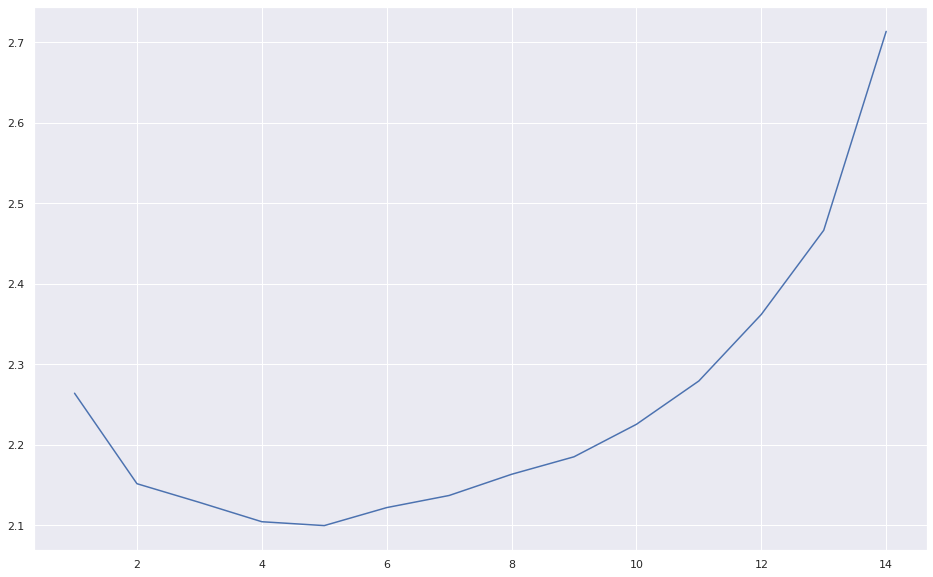

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.figure(figsize=(16,10))
sns.lineplot(list(range(1,15)),mapes_ltr)

In [ ]:
mapes_ltr

[3.623616272174885,
 3.3349330269734696,
 3.2124322325606496,
 3.131467292435982,
 3.090037420497798,
 3.024700601719506,
 2.99581974795566,
 2.9793001326409363,
 2.9776089011480065,
 2.9744113641915084,
 2.987066953195773,
 3.007677588677747,
 3.012369511008178,
 3.024556440597363]